In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install pandas numpy graphviz faker diagrams eralchemy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 25.0 MB/s eta 0:00:00


In [4]:
# import necessary libraries
# Data Cleaning & Manipulation
import pandas as pd
import numpy as np
import re
import os
from datetime import datetime
from dateutil import parser


# Visualization & ERD Creation
import matplotlib.pyplot as plt
from diagrams import Diagram
from graphviz import Digraph
from IPython.display import Image

# Mock Data Generation
from faker import Faker
import random
import json
import uuid



In [5]:

data_path = "/content/drive/MyDrive/Virtuagym Datasets"
os.listdir(data_path)

['netsuite.csv', 'salesforce.csv', 'stripe.csv', 'VirtuagymTask.ipynb']

In [5]:
# Read the data into dataframes

Stripe_df = pd.read_csv(os.path.join(data_path, 'stripe.csv'), index_col="Customer_ID")
NetSuite_df = pd.read_csv(os.path.join(data_path, 'netsuite.csv'), index_col="Stripe_ID")
Salesforce_df = pd.read_csv(os.path.join(data_path, 'salesforce.csv'), index_col="Stripe_ID")


In [6]:
Salesforce_df.head()


,Account_ID,Account_Name,Email,Phone_Number,Closed_Contract_Date
Stripe_ID,,,,,
PAY0713,SAL0906,Jamie Smith,jamiesmith@example.com,+91 5428082088,2024-01-01
PAY0621,SAL0840,Jordan Davis,jordandavis@example.com,+84 9116428507,2024-01-02
PAY0012,SAL0676,Taylor Brown,taylorbrown@example.com,+21 1230020161,2024-01-03
PAY0952,SAL0877,Jamie Thomas,jamiethomas@example.com,+43 6110943464,2024-01-04
PAY0295,SAL0244,Jamie Jackson,jamiejackson@example.com,+90 7614788357,2024-01-05


In [7]:
NetSuite_df.head()

,Customer_ID,Customer_Name,Revenue,Date
Stripe_ID,,,,
PAY0713,NET0902,Jamie Smith,4137.469558,01/03/2025
PAY0621,NET0389,Jordan Davis,950.255074,02/03/2025
PAY0012,NET0262,Taylor Brown,3538.000829,03/03/2025
PAY0952,NET0468,Jamie Thomas,2011.853581,04/03/2025
PAY0295,NET0986,Jamie Jackson,2762.458352,05/03/2025


In [11]:
Stripe_df.head()

,Customer_Name,Metadata_SAL_ID,Amount,Currency,Date
Customer_ID,,,,,
PAY0406,Morgan Wilson,SAL0584,"€494,53",EUR,"March 01, 2025"
PAY0922,Jamie Taylor,SAL0711,"€1,984.31",EUR,02/03/2025
PAY0012,Taylor Brown,SAL0676,"$1,878.89",USD,03/03/2025
PAY0040,Riley Johnson,SAL0682,"€1.696,47",EUR,"March 04, 2025"
PAY0221,Jordan Davis,SAL0843,€959.84,EUR,2025-03-05


In [18]:
# Create ERD

# Initialize Graph
erd = Digraph('virt_gym_erd_graphviz', format='png')
erd.attr(rankdir='LR')

# Stripe
erd.node('Stripe', '''Stripe_Payments
--------------------------
Customer_ID (PK)
Customer_Name
Metadata_SAL_ID (FK)
Amount
Currency
Date
''')

# Salesforce
erd.node('Salesforce', '''Salesforce_Accounts
-----------------------------
Account_ID (PK)
Stripe_ID (FK)
Account_Name
Email
Phone_Number
Closed_Contract_Date
''')

# NetSuite
erd.node('NetSuite', '''NetSuite_Revenue
--------------------------
Customer_ID (PK)
Stripe_ID (FK)
Customer_Name
Revenue
Date
''')

# Relationships (cleaned)
erd.edge('Stripe', 'Salesforce', label='Metadata_SAL_ID → Account_ID')
erd.edge('Salesforce', 'NetSuite', label='Stripe_ID → Stripe_ID')

# Render
erd.render('virt_gym_erd_graphviz', format='png', cleanup=False)



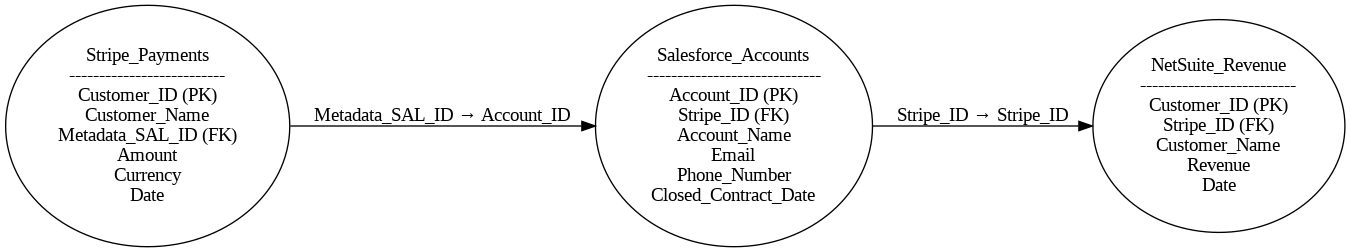

In [17]:
Image(filename='virt_gym_erd_graphviz.png')


In [18]:
Stripe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10506 entries, PAY0406 to PAY0683
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Customer_Name    10506 non-null  object
 1   Metadata_SAL_ID  9466 non-null   object
 2   Amount           10302 non-null  object
 3   Currency         10506 non-null  object
 4   Date             10506 non-null  object
dtypes: object(5)
memory usage: 750.5+ KB


In [19]:
# Clean Stripe Dataframe
Stripe_df.index = Stripe_df.index.astype(str).str.strip()
Stripe_df.index = Stripe_df.index.astype("string")
Stripe_df['Customer_Name'] = Stripe_df['Customer_Name'].astype(str).str.strip().astype("string")
Stripe_df['Currency'] = Stripe_df['Currency'].astype(str).str.strip().astype("string")

In [20]:
# Clean: Metadata_SAL_ID and keep NaN

def clean_metadata_id(val):
    if pd.isnull(val):
        return np.nan
    return str(val).strip()

Stripe_df['Metadata_SAL_ID'] = Stripe_df['Metadata_SAL_ID'].apply(clean_metadata_id).astype("string")

In [21]:
# Define func to clean amount appropriately
def clean_amount_pro(val):
    if pd.isnull(val):
        return np.nan

    val = val.replace('€', '').replace('$', '').replace(' ', '')

    # Clean US format
    if re.match(r'^\d{1,3}(,\d{3})*\.\d{2}$', val):
        val = val.replace(',', '')

    # Clean European format
    elif re.match(r'^\d{1,3}(\.\d{3})*,\d{2}$', val):
        val = val.replace('.', '').replace(',', '.')

    # European: 494,53 → 494.53
    elif ',' in val and '.' not in val:
        val = val.replace(',', '.')

    try:
        return float(val)
    except:
        return np.nan

# Apply function
Stripe_df['Amount_Cleaned'] = Stripe_df['Amount'].astype(str).apply(clean_amount_pro)


In [22]:
# Check for Currency Mismatches

def detect_currency_mismatch(row):
    amount = row['Amount']
    currency = row['Currency']
    if isinstance(amount, str):
        if '€' in amount and currency != 'EUR':
            return True
        elif '$' in amount and currency != 'USD':
            return True
    return False

mismatches = Stripe_df[Stripe_df.apply(detect_currency_mismatch, axis=1)]

# Display if any exist
print(f"Mismatched currency entries: {len(mismatches)}")


Mismatched currency entries: 0


In [23]:
# Clean Date

def safe_parse_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=False)
    except:
        return pd.NaT

Stripe_df['Date_Cleaned'] = Stripe_df['Date'].astype(str).apply(safe_parse_date)

In [24]:
# Flag dates in the future
today = datetime.today()
Stripe_df['Date_FutureFlag'] = Stripe_df['Date_Cleaned'] > today

In [25]:
Stripe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10506 entries, PAY0406 to PAY0683
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Customer_Name    10506 non-null  string        
 1   Metadata_SAL_ID  9466 non-null   string        
 2   Amount           10302 non-null  object        
 3   Currency         10506 non-null  string        
 4   Date             10506 non-null  object        
 5   Amount_Cleaned   10302 non-null  float64       
 6   Date_Cleaned     10506 non-null  datetime64[ns]
 7   Date_FutureFlag  10506 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(2), string(3)
memory usage: 924.9+ KB


In [26]:
# Check for missing values
Stripe_df.isna().sum()


,0
Customer_Name,0
Metadata_SAL_ID,1040
Amount,204
Currency,0
Date,0
Amount_Cleaned,204
Date_Cleaned,0
Date_FutureFlag,0


In [27]:
# Flag missing values in Metadata_SAL_ID
Stripe_df['Missing_SAL_ID'] = Stripe_df['Metadata_SAL_ID'].isna()


In [28]:
# Dropping rows missing amount
Stripe_df = Stripe_df[Stripe_df['Amount_Cleaned'].notna()]


<ipython-input-29-1f22e90b4d94>:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  stripe_grouped = Stripe_df.groupby(pd.Grouper(key='Date_Cleaned', freq='Q')).agg(


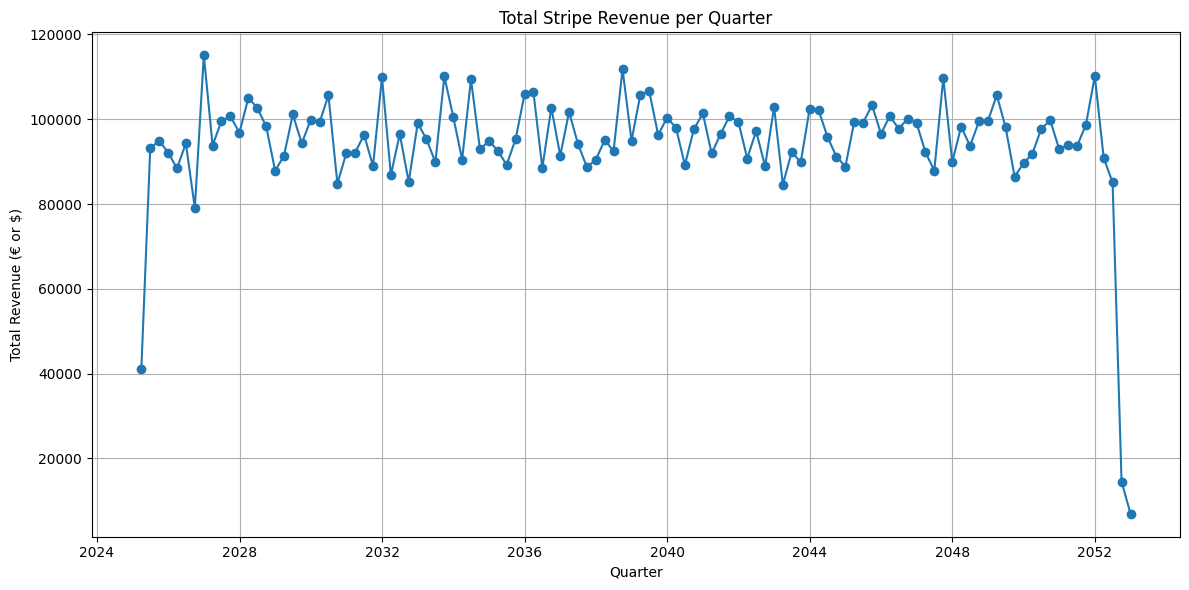

In [29]:
# Set up for grouping
stripe_grouped = Stripe_df.groupby(pd.Grouper(key='Date_Cleaned', freq='Q')).agg(
    Total_Revenue=('Amount_Cleaned', 'sum'),
    Transactions=('Amount_Cleaned', 'count')
).reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(stripe_grouped['Date_Cleaned'], stripe_grouped['Total_Revenue'], marker='o')
plt.title('Total Stripe Revenue per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue (€ or $)')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-30-e89eccf1c388>:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  pd.Grouper(key='Date_Cleaned', freq='Q'),


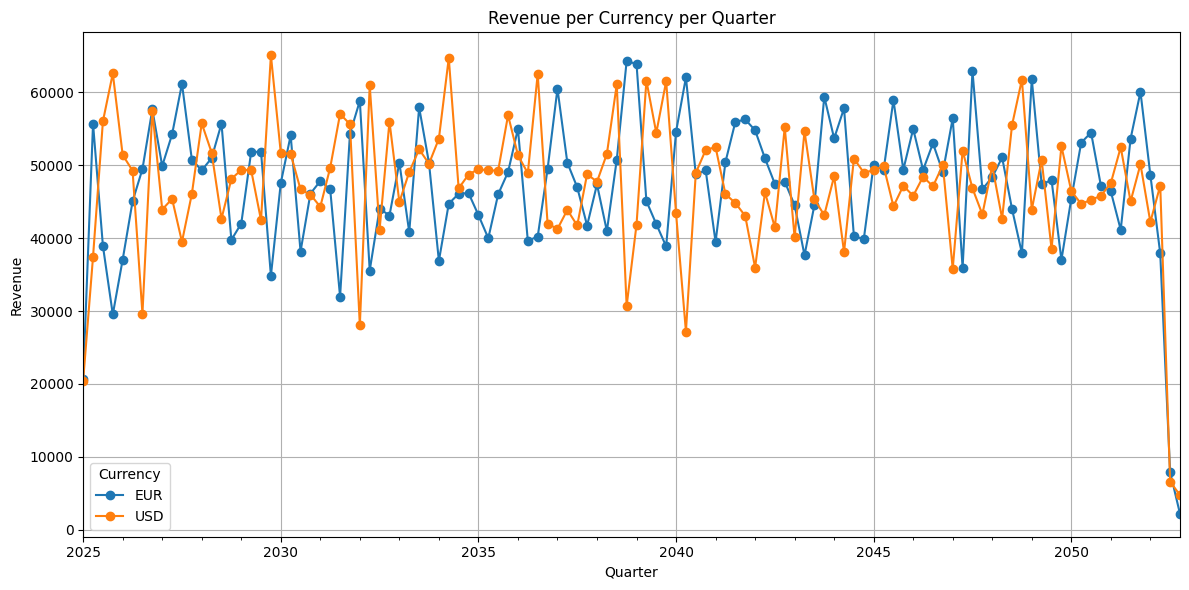

In [30]:
stripe_currency_grouped = Stripe_df.groupby([
    pd.Grouper(key='Date_Cleaned', freq='Q'),
    'Currency'
])['Amount_Cleaned'].sum().unstack()

stripe_currency_grouped.plot(figsize=(12, 6), marker='o')
plt.title('Revenue per Currency per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-31-50ec6c4b0c16>:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  pd.Grouper(key='Date_Cleaned', freq='Q')


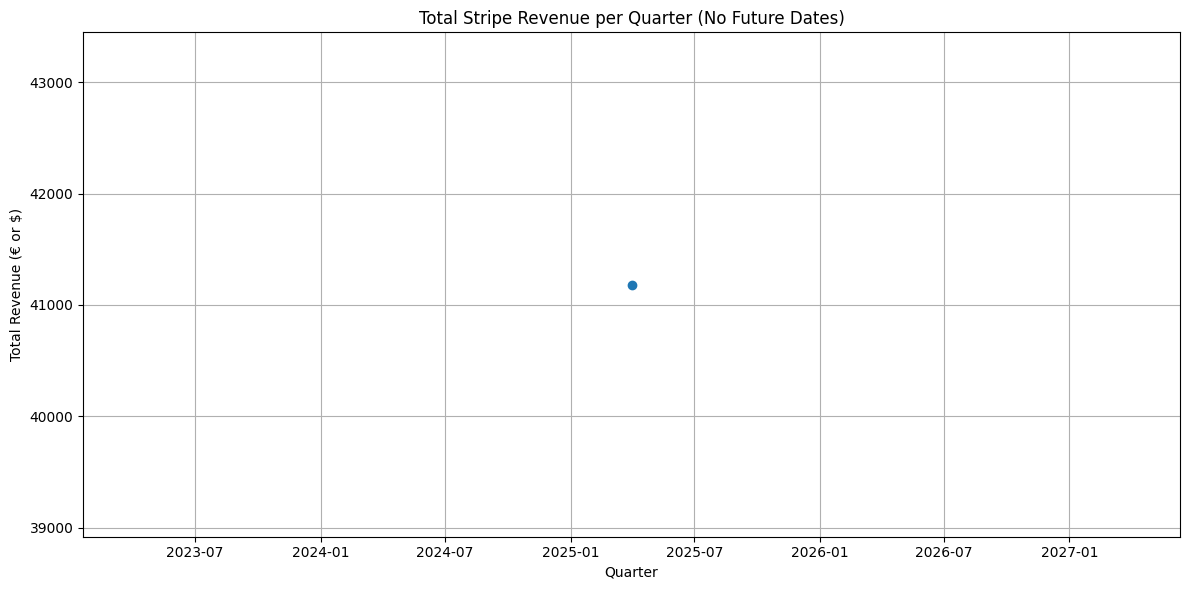

In [31]:
# Replot without future dates
# Get today's date
today = pd.Timestamp.today()

# Filter Stripe_df to include only records with a date <= today
Stripe_df_filtered = Stripe_df[Stripe_df['Date_Cleaned'] <= today]

# Group by quarter
grouped = Stripe_df_filtered.groupby(
    pd.Grouper(key='Date_Cleaned', freq='Q')
).agg(
    Total_Revenue=('Amount_Cleaned', 'sum'),
    Transactions=('Amount_Cleaned', 'count')
).reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(grouped['Date_Cleaned'], grouped['Total_Revenue'], marker='o')
plt.title('Total Stripe Revenue per Quarter (No Future Dates)')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue (€ or $)')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-32-c76f43bb56e7>:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  pd.Grouper(key='Date_Cleaned', freq='Q'),
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


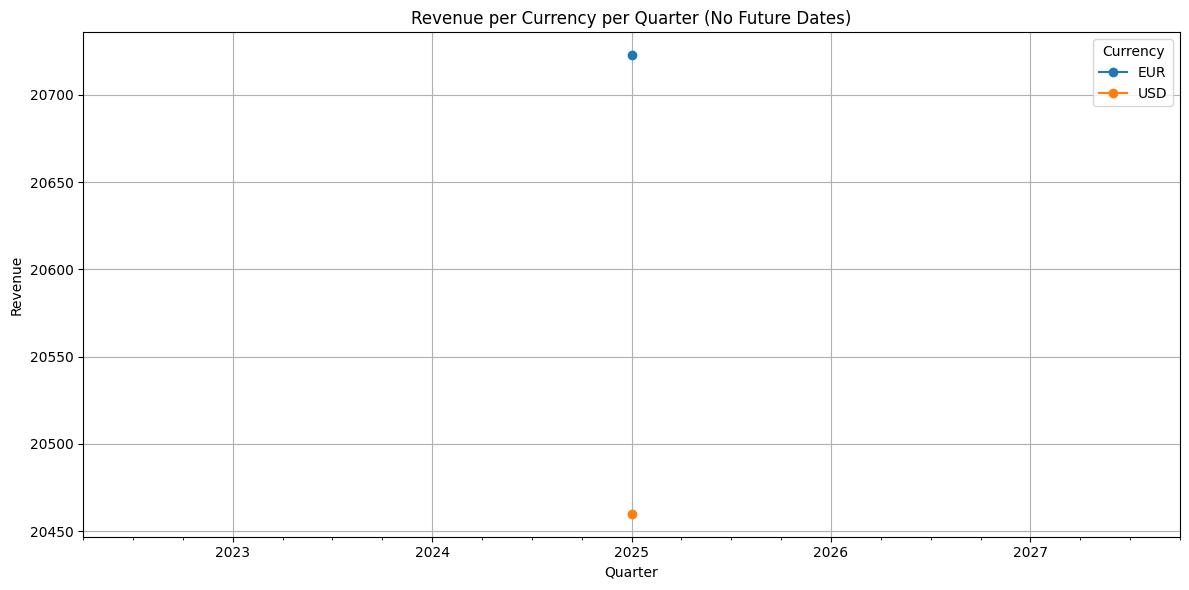

In [32]:
# Group by Quarter and Currency
currency_grouped = Stripe_df_filtered.groupby([
    pd.Grouper(key='Date_Cleaned', freq='Q'),
    'Currency'
])['Amount_Cleaned'].sum().unstack()

# Plot
currency_grouped.plot(figsize=(12, 6), marker='o')
plt.title('Revenue per Currency per Quarter (No Future Dates)')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# Save cleaned df and preview
stripe_df_clean = Stripe_df[Stripe_df['Date_Cleaned'] <= datetime.today()].copy()
stripe_df_clean.head()

,Customer_Name,Metadata_SAL_ID,Amount,Currency,Date,Amount_Cleaned,Date_Cleaned,Date_FutureFlag,Missing_SAL_ID
Customer_ID,,,,,,,,,
PAY0406,Morgan Wilson,SAL0584,"€494,53",EUR,"March 01, 2025",494.53,2025-03-01,False,False
PAY0922,Jamie Taylor,SAL0711,"€1,984.31",EUR,02/03/2025,1984.31,2025-02-03,False,False
PAY0012,Taylor Brown,SAL0676,"$1,878.89",USD,03/03/2025,1878.89,2025-03-03,False,False
PAY0040,Riley Johnson,SAL0682,"€1.696,47",EUR,"March 04, 2025",1696.47,2025-03-04,False,False
PAY0221,Jordan Davis,SAL0843,€959.84,EUR,2025-03-05,959.84,2025-03-05,False,False


In [34]:
# Clean Saleforce
Salesforce_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030 entries, PAY0713 to PAY0227
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Account_ID            1030 non-null   object
 1   Account_Name          1030 non-null   object
 2   Email                 1030 non-null   object
 3   Phone_Number          1030 non-null   object
 4   Closed_Contract_Date  1030 non-null   object
dtypes: object(5)
memory usage: 80.6+ KB


In [35]:
Salesforce_df.head()

,Account_ID,Account_Name,Email,Phone_Number,Closed_Contract_Date
Stripe_ID,,,,,
PAY0713,SAL0906,Jamie Smith,jamiesmith@example.com,+91 5428082088,2024-01-01
PAY0621,SAL0840,Jordan Davis,jordandavis@example.com,+84 9116428507,2024-01-02
PAY0012,SAL0676,Taylor Brown,taylorbrown@example.com,+21 1230020161,2024-01-03
PAY0952,SAL0877,Jamie Thomas,jamiethomas@example.com,+43 6110943464,2024-01-04
PAY0295,SAL0244,Jamie Jackson,jamiejackson@example.com,+90 7614788357,2024-01-05


In [36]:
# Clean index (Stripe_ID)
Salesforce_df.index = Salesforce_df.index.astype(str).str.strip().astype("string")

# Clean Account_ID & Account_Name
Salesforce_df['Account_ID'] = Salesforce_df['Account_ID'].astype(str).str.strip().astype("string")
Salesforce_df['Account_Name'] = Salesforce_df['Account_Name'].astype(str).str.strip().astype("string")

# Clean Email
Salesforce_df['Email'] = Salesforce_df['Email'].astype(str).str.strip().str.lower().astype("string")

# Clean Phone_Number
Salesforce_df['Phone_Number'] = Salesforce_df['Phone_Number'].astype(str).str.strip().astype("string")

# Parse Closed_Contract_Date to datetime
Salesforce_df['Closed_Contract_Date'] = pd.to_datetime(Salesforce_df['Closed_Contract_Date'], errors='coerce')


In [37]:
# Check for missing or invalid contract dates
print("Missing contract dates:", Salesforce_df['Closed_Contract_Date'].isna().sum())

# Check for duplicates in Account_ID
print("Duplicate Account_IDs:", Salesforce_df['Account_ID'].duplicated().sum())

# Quick look at result
Salesforce_df.info()
Salesforce_df.head()


Missing contract dates: 0
Duplicate Account_IDs: 30
<class 'pandas.core.frame.DataFrame'>
Index: 1030 entries, PAY0713 to PAY0227
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Account_ID            1030 non-null   string        
 1   Account_Name          1030 non-null   string        
 2   Email                 1030 non-null   string        
 3   Phone_Number          1030 non-null   string        
 4   Closed_Contract_Date  1030 non-null   datetime64[ns]
dtypes: datetime64[ns](1), string(4)
memory usage: 48.3 KB


,Account_ID,Account_Name,Email,Phone_Number,Closed_Contract_Date
Stripe_ID,,,,,
PAY0713,SAL0906,Jamie Smith,jamiesmith@example.com,+91 5428082088,2024-01-01
PAY0621,SAL0840,Jordan Davis,jordandavis@example.com,+84 9116428507,2024-01-02
PAY0012,SAL0676,Taylor Brown,taylorbrown@example.com,+21 1230020161,2024-01-03
PAY0952,SAL0877,Jamie Thomas,jamiethomas@example.com,+43 6110943464,2024-01-04
PAY0295,SAL0244,Jamie Jackson,jamiejackson@example.com,+90 7614788357,2024-01-05


In [38]:
# Check accounts with duplicate
Salesforce_df['Account_ID'].value_counts().head(10)


,count
Account_ID,
SAL0419,2
SAL0510,2
SAL0787,2
SAL0041,2
SAL0408,2
SAL0061,2
SAL0470,2
SAL0710,2
SAL0785,2


In [46]:
# Reset index column
NetSuite_df.reset_index(inplace=True)


In [47]:
NetSuite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Customer_ID    1030 non-null   string        
 1   Stripe_ID      980 non-null    string        
 2   Customer_Name  1030 non-null   object        
 3   Revenue        1009 non-null   float64       
 4   Date           410 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1), string(2)
memory usage: 40.4+ KB


In [48]:
# Preview
NetSuite_df.head()

,Customer_ID,Stripe_ID,Customer_Name,Revenue,Date
0,NET0902,PAY0713,Jamie Smith,4137.47,2025-01-03
1,NET0389,PAY0621,Jordan Davis,950.26,2025-02-03
2,NET0262,PAY0012,Taylor Brown,3538.00,2025-03-03
3,NET0468,PAY0952,Jamie Thomas,2011.85,2025-04-03
4,NET0986,PAY0295,Jamie Jackson,2762.46,2025-05-03


In [49]:
# Clean Dataframe
NetSuite_df['Stripe_ID'] = NetSuite_df['Stripe_ID'].astype(str).str.strip()
NetSuite_df['Stripe_ID'] = NetSuite_df['Stripe_ID'].replace('nan', pd.NA)
NetSuite_df['Stripe_ID'] = NetSuite_df['Stripe_ID'].astype("string")

NetSuite_df['Customer_ID'] = NetSuite_df['Customer_ID'].astype(str).str.strip().astype("string")

NetSuite_df['Revenue'] = pd.to_numeric(NetSuite_df['Revenue'], errors='coerce')
NetSuite_df['Revenue'] = NetSuite_df['Revenue'].round(2)

NetSuite_df['Date'] = pd.to_datetime(NetSuite_df['Date'], errors='coerce')



In [50]:
NetSuite_df.isna().sum()


,0
Customer_ID,0
Stripe_ID,0
Customer_Name,0
Revenue,21
Date,620


In [51]:
# Set customer ID (PK) as the index column
NetSuite_df.set_index('Customer_ID', inplace=True)

# Drop the extra index column
#NetSuite_df.drop(columns='index', inplace=True)



In [51]:
NetSuite_df.head()

,Stripe_ID,Customer_Name,Revenue,Date
Customer_ID,,,,
NET0902,PAY0713,Jamie Smith,4137.47,2025-01-03
NET0389,PAY0621,Jordan Davis,950.26,2025-02-03
NET0262,PAY0012,Taylor Brown,3538.00,2025-03-03
NET0468,PAY0952,Jamie Thomas,2011.85,2025-04-03
NET0986,PAY0295,Jamie Jackson,2762.46,2025-05-03


<ipython-input-52-450b7d9531b2>:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  pd.Grouper(key='Date', freq='Q')


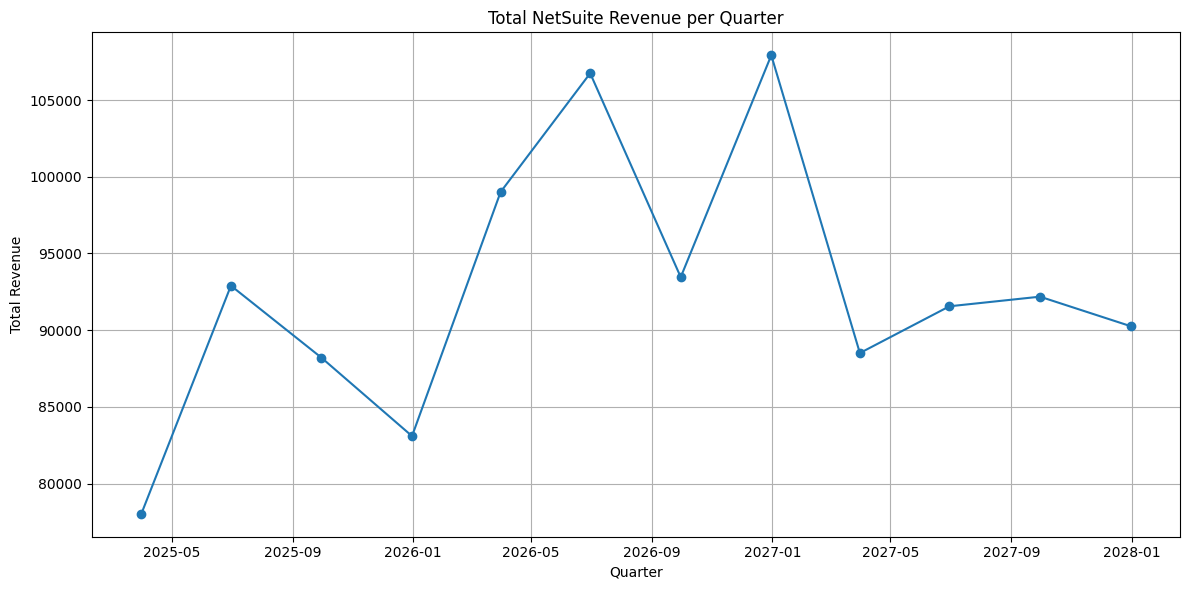

In [52]:
# Visaulize total revenue over time — grouped by quarter

# Group revenue by quarter
netsuite_grouped = NetSuite_df.groupby(
    pd.Grouper(key='Date', freq='Q')
)['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(netsuite_grouped['Date'], netsuite_grouped['Revenue'], marker='o')
plt.title('Total NetSuite Revenue per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

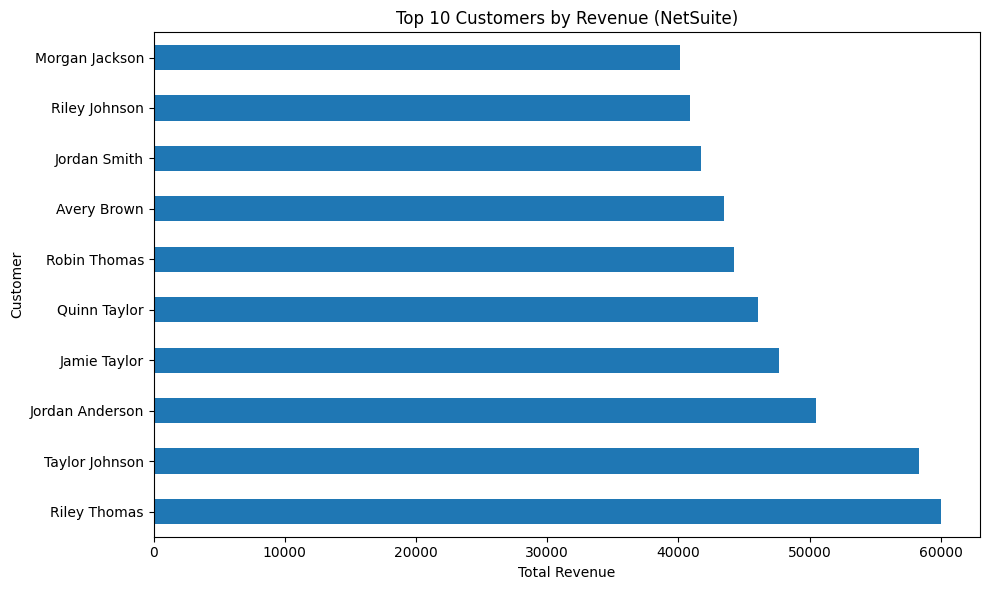

In [53]:
# Visualize Revenue per Customer (Top 10)
top_customers = NetSuite_df.groupby('Customer_Name')['Revenue'].sum().nlargest(10)

# Plot
top_customers.plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Customers by Revenue (NetSuite)')
plt.xlabel('Total Revenue')
plt.ylabel('Customer')
plt.tight_layout()
plt.show()

In [67]:
# Merge cleaned data and preview
merged_df = stripe_df_clean.merge(
    Salesforce_df, how='left', left_on='Customer_ID', right_index=True
).merge(
    NetSuite_df, how='left', left_on='Customer_ID', right_on='Stripe_ID'
)


In [68]:
merged_df.set_index('Stripe_ID', inplace=True)


In [69]:
merged_df.shape

(42, 17)

In [54]:
# Get sets of Stripe_IDs (index) from each dataframe
stripe_ids_stripe = set(stripe_df_clean.index)
stripe_ids_salesforce = set(Salesforce_df.index)
stripe_ids_netsuite = set(NetSuite_df['Stripe_ID'].dropna())  # Since Stripe_ID is not index in NetSuite yet

# Find the intersection
intersect_ids = stripe_ids_stripe & stripe_ids_salesforce & stripe_ids_netsuite

# Display count and a sample
print(f"🔗 Number of common Stripe_IDs across all 3 datasets: {len(intersect_ids)}")
print("🧾 Sample intersecting IDs:", list(intersect_ids)[:10])


🔗 Number of common Stripe_IDs across all 3 datasets: 39
🧾 Sample intersecting IDs: ['PAY0137', 'PAY0923', 'PAY0606', 'PAY0827', 'PAY0605', 'PAY0922', 'PAY0777', 'PAY0297', 'PAY0888', 'PAY0393']


In [60]:
# Re-do the first merge, but keep Stripe_ID
stripe_salesforce_merged = stripe_df_clean.reset_index().merge(
    Salesforce_df,
    how='left',
    left_on='Metadata_SAL_ID',
    right_on='Account_ID'
)




In [62]:
stripe_salesforce_merged.shape
stripe_salesforce_merged.head()

,Customer_ID,Customer_Name,Metadata_SAL_ID,Amount,Currency,Date,Amount_Cleaned,Date_Cleaned,Date_FutureFlag,Missing_SAL_ID,Account_ID,Account_Name,Email,Phone_Number,Closed_Contract_Date
0,PAY0406,Morgan Wilson,SAL0584,"€494,53",EUR,"March 01, 2025",494.53,2025-03-01,False,False,SAL0584,Morgan Wilson,morganwilson@example.com,+81 6939036170,2026-05-26
1,PAY0922,Jamie Taylor,SAL0711,"€1,984.31",EUR,02/03/2025,1984.31,2025-02-03,False,False,SAL0711,Jamie Taylor,jamietaylor@example.com,+97 3532855799,2024-01-24
2,PAY0012,Taylor Brown,SAL0676,"$1,878.89",USD,03/03/2025,1878.89,2025-03-03,False,False,SAL0676,Taylor Brown,taylorbrown@example.com,+21 1230020161,2024-01-03
3,PAY0040,Riley Johnson,SAL0682,"€1.696,47",EUR,"March 04, 2025",1696.47,2025-03-04,False,False,SAL0682,Quinn Smith,quinnsmith@example.com,+58 1683855081,2024-11-30
4,PAY0221,Jordan Davis,SAL0843,€959.84,EUR,2025-03-05,959.84,2025-03-05,False,False,SAL0843,Jordan Davis,jordandavis@example.com,+15 8030400668,2025-06-14


In [64]:
# 2. Now merge with NetSuite on Stripe_ID
merged_df_v2 = stripe_salesforce_merged.merge(
    NetSuite_df,
    how='left',
    left_on='Customer_ID',
    right_index=True  # since Stripe_ID is index in NetSuite
)



In [65]:
merged_df_v2.shape

(43, 19)

In [83]:
merged_df_v2.head()

,Customer_ID,Customer_Name_x,Metadata_SAL_ID,Amount,Currency,Date_x,Amount_Cleaned,Date_Cleaned,Date_FutureFlag,Missing_SAL_ID,Account_ID,Account_Name,Email,Phone_Number,Closed_Contract_Date,Stripe_ID,Customer_Name_y,Revenue,Date_y
0,PAY0406,Morgan Wilson,SAL0584,"€494,53",EUR,"March 01, 2025",494.53,2025-03-01,False,False,SAL0584,Morgan Wilson,morganwilson@example.com,+81 6939036170,2026-05-26,<NA>,NaN,NaN,NaT
1,PAY0922,Jamie Taylor,SAL0711,"€1,984.31",EUR,02/03/2025,1984.31,2025-02-03,False,False,SAL0711,Jamie Taylor,jamietaylor@example.com,+97 3532855799,2024-01-24,<NA>,NaN,NaN,NaT
2,PAY0012,Taylor Brown,SAL0676,"$1,878.89",USD,03/03/2025,1878.89,2025-03-03,False,False,SAL0676,Taylor Brown,taylorbrown@example.com,+21 1230020161,2024-01-03,<NA>,NaN,NaN,NaT
3,PAY0040,Riley Johnson,SAL0682,"€1.696,47",EUR,"March 04, 2025",1696.47,2025-03-04,False,False,SAL0682,Quinn Smith,quinnsmith@example.com,+58 1683855081,2024-11-30,<NA>,NaN,NaN,NaT
4,PAY0221,Jordan Davis,SAL0843,€959.84,EUR,2025-03-05,959.84,2025-03-05,False,False,SAL0843,Jordan Davis,jordandavis@example.com,+15 8030400668,2025-06-14,<NA>,NaN,NaN,NaT


In [72]:
# Q1: What is the email of the customer associated with the single largest payment?

largest_payment = merged_df_v2.loc[merged_df_v2['Amount_Cleaned'].idxmax()]
email_largest = largest_payment['Email']
amount_largest = largest_payment['Amount_Cleaned']
currency_largest = largest_payment['Currency']
name_largest = largest_payment['Customer_Name_x']

print(f"{name_largest} ({email_largest}) made the largest single payment of {currency_largest} {amount_largest:,.2f} to VirtuaGym.")


Jamie Taylor (jamietaylor@example.com) made the largest single payment of EUR 1,984.31 to VirtuaGym.


In [77]:
# Q2: What are the CRM details of the customer that made the highest number of transactions?

# Count transactions per Customer_ID
txn_counts = merged_df_v2['Customer_ID'].value_counts()
top_stripe_id = txn_counts.idxmax()
top_txn_count = txn_counts.max()

# Extract CRM details
top_crm = merged_df_v2[merged_df_v2['Customer_ID'] == top_stripe_id][[
    'Customer_ID', 'Account_ID', 'Account_Name', 'Email', 'Phone_Number', 'Closed_Contract_Date'
]].drop_duplicates()

print("Customer with the highest number of transactions:")
display(top_crm)
print(f"\nTotal transactions: {top_txn_count}")


Customer with the highest number of transactions:


,Customer_ID,Account_ID,Account_Name,Email,Phone_Number,Closed_Contract_Date
29,PAY0597,SAL0202,Riley Moore,rileymoore@example.com,+4 9740924080,2025-05-19



Total transactions: 2


In [80]:
#  What is the total revenue and total cash received per customer based on NetSuite and Stripe data respectively?

# Grouping by Customer_ID for alignment
aggregated = merged_df_v2.groupby('Customer_ID').agg({
    'Amount_Cleaned': 'sum',
    'Revenue': 'sum',
    'Email': 'first'
}).rename(columns={
    'Amount_Cleaned': 'Total_Cash_Received (Stripe)',
    'Revenue': 'Total_Revenue (NetSuite)'
}).reset_index()

# Preview top 10 rows
print("Summary of Total Cash Received (Stripe) and Revenue (NetSuite) per Customer:\n")
print(aggregated.head(10).to_string(index=False))


Summary of Total Cash Received (Stripe) and Revenue (NetSuite) per Customer:

Customer_ID  Total_Cash_Received (Stripe)  Total_Revenue (NetSuite)                     Email
    PAY0012                       1878.89                       0.0   taylorbrown@example.com
    PAY0040                       1696.47                       0.0    quinnsmith@example.com
    PAY0073                       1332.47                       0.0   jamiethomas@example.com
    PAY0097                        298.98                       0.0  robinjackson@example.com
    PAY0137                        161.95                       0.0 jamieanderson@example.com
    PAY0145                        511.65                       0.0   morgandavis@example.com
    PAY0146                       2744.22                       0.0     alexmoore@example.com
    PAY0203                       2355.80                       0.0   quinnwilson@example.com
    PAY0221                        959.84                       0.0   jordan

# Q4: What issues do you notice about the connection between Systems?

From the outputs, I can ascertain that the primary issue is inconsistent linkage keys across systems. While the Stripe–Salesforce integration via Metadata_SAL_ID and Account_ID was mostly successful, the NetSuite dataset failed to join meaningfully due to mismatched or missing Stripe_ID values. As a result, most records in the final merged dataset lacked revenue data from NetSuite. This fragmentation highlights the absence of a unified customer identifier across all systems, which severely limits complete cross-system analysis.



In [10]:
# Create Updated ERD

erd = Digraph('virt_gym_erd_updated', format='png')
erd.attr(rankdir='LR')

# Stripe_Payments
erd.node('Stripe', '''Stripe_Payments
--------------------------
Customer_ID (PK)
Customer_Name
Metadata_SAL_ID (FK)
Amount
Currency
Date
''')

# Salesforce_Accounts
erd.node('Salesforce', '''Salesforce_Accounts
-----------------------------
Account_ID (PK)
Stripe_ID (FK)
Account_Name
Email
Phone_Number
Closed_Contract_Date
''')

# NetSuite_Revenue
erd.node('NetSuite', '''NetSuite_Revenue
--------------------------
Customer_ID (PK)
Stripe_ID (FK)
Customer_Name
Revenue
Date
''')

# CustomerSupportActivity
erd.node('Support', '''CustomerSupportActivity
-----------------------------
Ticket_ID (PK)
Customer_ID (FK)
Date_Opened
Date_Closed
Interaction_Type
Channel
Status
Satisfaction_score
Support_Agent
''')

# Relationships
erd.edge('Stripe', 'Salesforce', label='Metadata_SAL_ID → Account_ID')
erd.edge('Salesforce', 'NetSuite', label='Stripe_ID → Stripe_ID')
erd.edge('Support', 'Stripe', label='Customer_ID → Customer_ID')

# Render ERD
erd_path = '/content/drive/MyDrive/Virtuagym Datasets/virt_gym_erd_updated.png'
erd.render('/content/drive/MyDrive/Virtuagym Datasets/virt_gym_erd_updated', format='png', cleanup=True)


'/content/drive/MyDrive/Virtuagym Datasets/virt_gym_erd_updated.png'

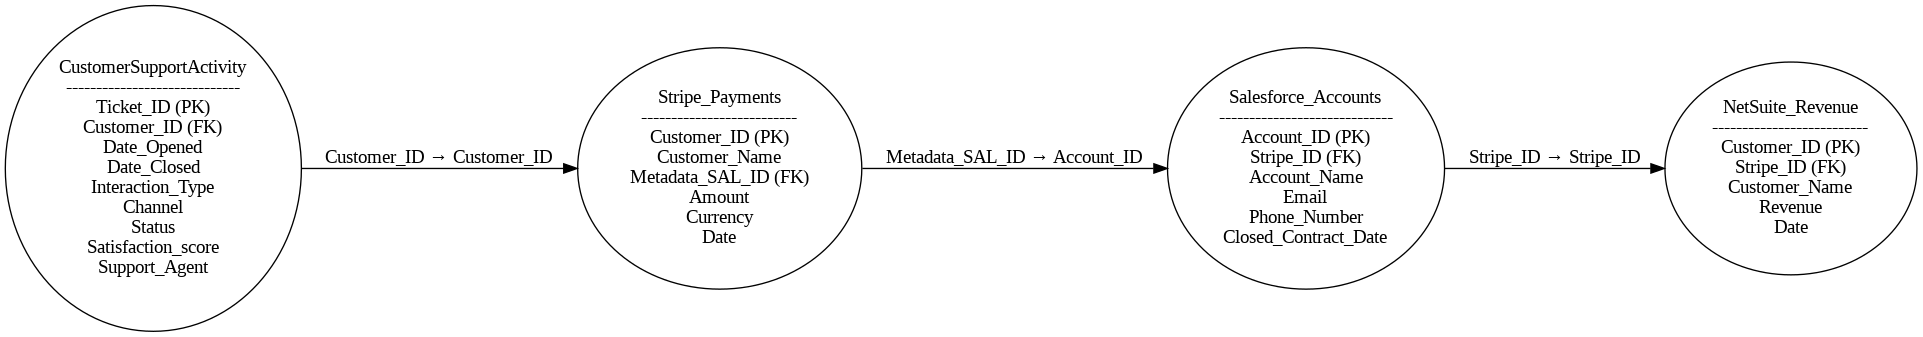

In [11]:
Image(filename='/content/virt_gym_erd_updated.png')


In [12]:
# Generate Mock Data
faker = Faker()
support_data = []

interaction_types = [
    "Complaint", "Refund Request", "Billing Issue", "Usage Inquiry",
    "Feature Request", "Bug Report"
]
channels = ["Email", "Phone", "Chat"]
statuses = ["Open", "Resolved", "In Progress"]

for _ in range(100):
    opened = faker.date_time_between(start_date='-1y', end_date='now')
    closed = faker.date_time_between(start_date=opened) if random.random() > 0.3 else None
    support_data.append({
        "Ticket_ID": str(uuid.uuid4()),
        "Customer_ID": f"PAY{random.randint(1000, 9999)}",
        "Date_Opened": opened.isoformat(),
        "Date_Closed": closed.isoformat() if closed else None,
        "Interaction_Type": random.choice(interaction_types),
        "Channel": random.choice(channels),
        "Status": random.choice(statuses),
        "Satisfaction_score": random.randint(1, 5),
        "Support_Agent": faker.name()
    })

# Save to JSON
mock_path = '/content/drive/MyDrive/Virtuagym Datasets/customer_support_activity.json'
with open(mock_path, 'w') as f:
    json.dump(support_data, f, indent=4)


In [15]:
# Read mock data
with open(mock_path, 'r') as fp:
  handle = json.load(fp)
  print(handle)


[{'Ticket_ID': '00118726-bc1d-4665-9548-435a168808f0', 'Customer_ID': 'PAY4544', 'Date_Opened': '2025-03-10T23:40:31.570771', 'Date_Closed': '2025-03-25T14:42:14.775795', 'Interaction_Type': 'Refund Request', 'Channel': 'Phone', 'Status': 'Resolved', 'Satisfaction_score': 2, 'Support_Agent': 'Laurie Mcmahon'}, {'Ticket_ID': '03956d40-2302-4913-b414-280cd498f0a7', 'Customer_ID': 'PAY6154', 'Date_Opened': '2024-05-01T07:32:15.550785', 'Date_Closed': '2024-06-23T15:27:18.999220', 'Interaction_Type': 'Refund Request', 'Channel': 'Email', 'Status': 'Open', 'Satisfaction_score': 2, 'Support_Agent': 'Robert Reyes'}, {'Ticket_ID': 'fd896b9f-f9d0-4cea-8553-da04498e1163', 'Customer_ID': 'PAY6354', 'Date_Opened': '2024-04-30T01:50:24.858670', 'Date_Closed': '2025-01-29T00:18:47.629741', 'Interaction_Type': 'Usage Inquiry', 'Channel': 'Chat', 'Status': 'In Progress', 'Satisfaction_score': 1, 'Support_Agent': 'Eric Hanson'}, {'Ticket_ID': '53bdd4e7-702f-4f8a-9d67-05c494c7d08e', 'Customer_ID': 'PAY8